In [1]:
import pandas
import datetime
import urllib
import bs4
import numpy
import lmfit
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
def convert_mlon_to_mlt(row):
    currDate = row["date"]
    currMLT = aacgm.mltFromYmdhms(\
                      currDate.year, currDate.month,
                                currDate.day, currDate.hour,
                                currDate.minute, currDate.second,
                                row["BndMlon"]) 
    currMLT = round(currMLT * 10) / 10
    return currMLT

In [3]:
# get dst index vals from wdc kyoto website
# create a list of dates with monthly freq
date_dst_arr = []
dst_val = []
dst_time_del = datetime.timedelta(hours = 1)
start_date = datetime.datetime(2011,1,1)
end_date = datetime.datetime(2014,12,31)
daterange = pandas.date_range(start_date, end_date, freq="M")
for dt in daterange:
    if dt.month <= 9:
            monthStr = "0" + str(dt.month)
    else:
        monthStr = str(dt.month)
    if dt.year >= 2015:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_realtime" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    elif ( (dt.year > 2012) and (dt.year < 2015) ):
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_provisional" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    else:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_final" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    conn = urllib.urlopen(currUrl)
    htmlSource = conn.read()
    soup = bs4.BeautifulSoup(htmlSource, 'html.parser')
    dataResObj = soup.find("pre", { "class" : "data" })
    # get the data as a list of strings after removing white space
    lines = dataResObj.text.strip().splitlines()
    for line in lines[6:]:
        columns = line.split()
        if len( columns ) > 0. :
            date_dst_arr.append( datetime.datetime( \
                dt.year, dt.month, int(columns[0]), 1 ) )
            for cols in range( len( columns[1:] ) ) :
                try:
                    inNumberFloatTest = float(columns[cols + 1])
                except:
                    # split these cols as well and work on them!
                    try:
                        missedCols = columns[cols + 1].split("-")[1:]
                        if len(missedCols) >= 1:
                            for mcols in missedCols:
                                dst_val.append( -1*float( mcols ) )
                                # now since we added the date earlier we need to be
                                # careful about appending date values
                                if ( len(date_dst_arr) != len(dst_val) ):
                                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
                    except:
                        print "something wrong with messed up vals!-->", columns[cols + 1]
                        continue
                    continue
                # I have to do this because of the messed up way Kyoto puts up the latest dst value..
                # mixed with 9999 (fillers) like if latest dst is 1 then Kyoto puts it as 199999.....
                if len( columns[ cols + 1 ] ) < 5 :
                    dst_val.append( float( columns[ cols + 1 ] ) )
                elif ( len( columns[ cols + 1 ] ) > 5 and columns[ cols + 1 ][0:3] != '999' ) :
                    mixed_messed_dst = ''
                    for jj in range(5) :
                        if columns[ cols + 1 ][jj] != '9' :
                            mixed_messed_dst = mixed_messed_dst + columns[ cols + 1 ][jj]

                    if mixed_messed_dst != '-' :
                        dst_val.append( float( mixed_messed_dst ) )
                    else :
                        dst_val.append( float( 'nan' ) )
                else :
                    dst_val.append( float( 'nan' ) )
                if cols > 0 :
                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
# convert dst data to a dataframe
dstDF = pandas.DataFrame(
    {'dst_date': date_dst_arr,
     'dst_index': dst_val
    })
dstDF["dateStr"] = dstDF["dst_date"].map(lambda x: x.strftime('%Y%m%d'))
dstDF["hour"] = dstDF["dst_date"].map(lambda x: x.strftime('%H'))
dstDF.head()

,dst_date,dst_index,dateStr,hour
0,2011-01-01 01:00:00,-11.0,20110101,01
1,2011-01-01 02:00:00,-11.0,20110101,02
2,2011-01-01 03:00:00,-9.0,20110101,03
3,2011-01-01 04:00:00,-5.0,20110101,04
4,2011-01-01 05:00:00,-3.0,20110101,05


In [4]:
fltdTrghLocFname = "../data/finTrghLocFltrd.txt"
fltTecDataDF = pandas.read_csv(fltdTrghLocFname, sep=' ',\
                            parse_dates=["date"],\
                               infer_datetime_format=True)
# add the dateStr and hour columns to join with Dst DF
fltTecDataDF["dateStr"] = fltTecDataDF["date"].map(lambda x: x.strftime('%Y%m%d'))
fltTecDataDF["hour"] = fltTecDataDF["date"].map(lambda x: x.strftime('%H'))
# Merge with Dst DF 
fltTecDataDF = pandas.merge( fltTecDataDF, dstDF, on=["dateStr", "hour"] )
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
fltTecDataDF = pandas.concat( [ fltTecDataDF, \
                    pandas.cut( fltTecDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
fltTecDataDF.columns = [ 'BndEquMlat', 'BndEquTecVal', 'BndMlon', 'BndPolMlat',
                       'BndPolTecVal', 'date', 'minFltrdTecVal', 'minTecMlat',
                       'minTecVal', 'dateStr', 'hour', 'dst_date',
                       'dst_index', 'dst_bin' ]
# GET MLT from MLON
fltTecDataDF["BndMLT"] = fltTecDataDF.apply( convert_mlon_to_mlt, axis=1 )
# GET NORMMLT
fltTecDataDF['BndNormMLT'] = [x-24 if x >= 12 else x for x in fltTecDataDF['BndMLT']]
# Round to nearest half
# fltTecDataDF['BndNormMLTRnd'] = [ round(x * 4) / 4 for x in fltTecDataDF['BndNormMLT'] ]
fltTecDataDF.head()

,BndEquMlat,BndEquTecVal,BndMlon,BndPolMlat,BndPolTecVal,date,minFltrdTecVal,minTecMlat,minTecVal,dateStr,hour,dst_date,dst_index,dst_bin,BndMLT,BndNormMLT
0,54.0,8.6,0.0,66.0,8.5,2011-04-03 04:00:00,3.842307,59.0,3.5,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.2,-0.8
1,54.0,8.1,2.0,64.0,4.4,2011-04-03 04:00:00,3.577432,60.0,3.6,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.3,-0.7
2,52.0,9.4,4.0,64.0,3.3,2011-04-03 04:00:00,3.461533,60.0,3.6,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.4,-0.6
3,51.0,9.0,6.0,65.0,6.7,2011-04-03 04:00:00,3.465488,60.0,3.8,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.6,-0.4
4,51.0,7.8,8.0,65.0,6.7,2011-04-03 04:00:00,3.501541,59.0,3.3,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.7,-0.3


In [5]:
# Apply some filters to weed out some bad data/events
# 1) data size by MLT and dst_bin
sizeMLTDstDF = fltTecDataDF.groupby( [ "BndNormMLT", "dst_bin" ] ).size().reset_index()
sizeMLTDstDF.columns = [ "BndNormMLT", "dst_bin", "size" ]
# Now we'll calculate percentage of data at each MLT
# We calculate the percentages by grouping data by dst_bins
# similar to our PSAPS calculation
maxSizeDst = sizeMLTDstDF.groupby( "dst_bin" ).max().reset_index()
maxSizeDst = maxSizeDst[ ["dst_bin", "size"] ]
maxSizeDst.columns = [ "dst_bin", "max_size" ]
# Join the maxsize with countDF to get %
sizeMLTDstDF = pandas.merge( sizeMLTDstDF, maxSizeDst, on="dst_bin" )
sizeMLTDstDF["perc_occ"] = sizeMLTDstDF["size"]/sizeMLTDstDF["max_size"]
# Select only those data points which have more than 20% prob of occ
sizeMLTDstDF = sizeMLTDstDF[ \
                    sizeMLTDstDF["perc_occ"] >= 0.2\
                    ].reset_index(drop=True)
# Now limit fltTecDataDF to only those dst_bin, MLT combinations
fltTecDataDF = pandas.merge( fltTecDataDF, sizeMLTDstDF,\
                            on=["BndNormMLT", "dst_bin"], how="inner" )
# Calculate Trgh Depth and gradient (both poleward and equ)
fltTecDataDF["polTrghDepth"] = fltTecDataDF["BndPolTecVal"] - fltTecDataDF["minTecVal"]
fltTecDataDF["polTrghGrad"] = fltTecDataDF["polTrghDepth"]/( fltTecDataDF["BndPolMlat"] - fltTecDataDF["minTecMlat"] )
fltTecDataDF["equTrghDepth"] = fltTecDataDF["BndEquTecVal"] - fltTecDataDF["minTecVal"]
fltTecDataDF["equTrghGrad"] = fltTecDataDF["equTrghDepth"]/( fltTecDataDF["BndEquMlat"] - fltTecDataDF["minTecMlat"] )
fltTecDataDF.head()

,BndEquMlat,BndEquTecVal,BndMlon,BndPolMlat,BndPolTecVal,date,minFltrdTecVal,minTecMlat,minTecVal,dateStr,...,dst_bin,BndMLT,BndNormMLT,size,max_size,perc_occ,polTrghDepth,polTrghGrad,equTrghDepth,equTrghGrad
0,54.0,8.6,0.0,66.0,8.5,2011-04-03 04:00:00,3.842307,59.0,3.5,20110403,...,"(-50, -25]",23.2,-0.8,955,1044,0.914751,5.0,0.714286,5.1,-1.020000
1,54.0,8.6,0.0,66.0,8.5,2011-04-03 04:05:00,3.842307,59.0,3.5,20110403,...,"(-50, -25]",23.2,-0.8,955,1044,0.914751,5.0,0.714286,5.1,-1.020000
2,54.0,6.9,354.0,64.0,6.2,2011-04-03 04:25:00,4.160481,60.0,3.7,20110403,...,"(-50, -25]",23.2,-0.8,955,1044,0.914751,2.5,0.625000,3.2,-0.533333
3,55.0,6.7,352.0,64.0,6.1,2011-04-03 04:35:00,3.571449,60.0,2.9,20110403,...,"(-50, -25]",23.2,-0.8,955,1044,0.914751,3.2,0.800000,3.8,-0.760000
4,55.0,6.9,350.0,64.0,5.9,2011-04-03 04:45:00,3.244549,60.0,2.3,20110403,...,"(-50, -25]",23.2,-0.8,955,1044,0.914751,3.6,0.900000,4.6,-0.920000


In [6]:
# Get dst median value for use during fitting later
dstMedDF = fltTecDataDF[ ["dst_bin", "dst_index"] ]
dstMedDF = dstMedDF.groupby( ["dst_bin"] ).median().reset_index()
dstMedDF.columns = [ "dst_bin", "dst_median" ]
fltTecDataDF = pandas.merge( fltTecDataDF, dstMedDF, on="dst_bin" )
fltTecDataDF.head()

,BndEquMlat,BndEquTecVal,BndMlon,BndPolMlat,BndPolTecVal,date,minFltrdTecVal,minTecMlat,minTecVal,dateStr,...,BndMLT,BndNormMLT,size,max_size,perc_occ,polTrghDepth,polTrghGrad,equTrghDepth,equTrghGrad,dst_median
0,54.0,8.6,0.0,66.0,8.5,2011-04-03 04:00:00,3.842307,59.0,3.5,20110403,...,23.2,-0.8,955,1044,0.914751,5.0,0.714286,5.1,-1.020000,-36.0
1,54.0,8.6,0.0,66.0,8.5,2011-04-03 04:05:00,3.842307,59.0,3.5,20110403,...,23.2,-0.8,955,1044,0.914751,5.0,0.714286,5.1,-1.020000,-36.0
2,54.0,6.9,354.0,64.0,6.2,2011-04-03 04:25:00,4.160481,60.0,3.7,20110403,...,23.2,-0.8,955,1044,0.914751,2.5,0.625000,3.2,-0.533333,-36.0
3,55.0,6.7,352.0,64.0,6.1,2011-04-03 04:35:00,3.571449,60.0,2.9,20110403,...,23.2,-0.8,955,1044,0.914751,3.2,0.800000,3.8,-0.760000,-36.0
4,55.0,6.9,350.0,64.0,5.9,2011-04-03 04:45:00,3.244549,60.0,2.3,20110403,...,23.2,-0.8,955,1044,0.914751,3.6,0.900000,4.6,-0.920000,-36.0


In [7]:
# Get MEAN and STD of diff quantities
trghStatDF = fltTecDataDF.groupby( [ "BndNormMLT", "dst_bin" ] ).mean().reset_index()
trghStdDF = fltTecDataDF.groupby( [ "BndNormMLT", "dst_bin" ] ).std().reset_index() 
# Need to replace col names of std df to avoid conf
newColList = []
for col in trghStdDF.columns:
    if ( (col == "BndNormMLT") | (col == "dst_bin") ):
        newCol = col
    else:
        newCol = "std_" + col
    newColList.append( newCol )
trghStdDF.columns = newColList
trghStatDF = pandas.merge( trghStatDF, \
                          trghStdDF,\
                          on=[ "BndNormMLT", "dst_bin" ] )
trghStatDF.dropna(inplace=True)
trghStatDF = trghStatDF.round(2)
trghStatDF.head()

,BndNormMLT,dst_bin,BndEquMlat,BndEquTecVal,BndMlon,BndPolMlat,BndPolTecVal,minFltrdTecVal,minTecMlat,minTecVal,...,std_dst_index,std_BndMLT,std_size,std_max_size,std_perc_occ,std_polTrghDepth,std_polTrghGrad,std_equTrghDepth,std_equTrghGrad,std_dst_median
0,-7.9,"(-150, -75]",56.11,15.74,279.91,66.28,8.41,7.26,63.24,6.67,...,12.33,0.0,0.0,0.0,0.0,2.32,0.58,6.11,0.60,0.0
1,-7.8,"(-150, -75]",56.41,16.32,283.06,66.69,8.31,7.45,63.33,6.96,...,13.10,0.0,0.0,0.0,0.0,0.83,0.28,7.54,0.77,0.0
2,-7.7,"(-150, -75]",56.93,14.31,282.48,66.62,8.01,7.04,63.29,6.55,...,12.76,0.0,0.0,0.0,0.0,0.95,0.29,7.00,0.78,0.0
3,-7.6,"(-150, -75]",56.73,14.40,283.90,66.33,7.97,6.92,62.89,6.40,...,11.64,0.0,0.0,0.0,0.0,1.14,0.39,6.51,0.73,0.0
4,-7.6,"(-75, -50]",57.50,12.09,275.70,67.14,7.03,5.96,63.71,5.40,...,6.78,0.0,0.0,0.0,0.0,0.94,0.33,4.77,0.78,0.0


In [50]:
# In this section we do the fitting 
# We'll have two ( types ) fits...
# 1) prob of occ of trough at a given MLT
# 2) trough MLAT (both boundaries and min pos)
# at a given MLT.
# Define model gaussian function
testDF = trghStatDF[ trghStatDF["dst_bin"] == "(-10, 10]" ]
def exp_fit_func( mltDstInp, a, k, c ):
    normMLT = mltDstInp[:,0]
    return a * numpy.exp(k * normMLT) + c
gmodel = lmfit.Model(exp_fit_func)
# NOTE you need to give a starting value for the fit...
# otherwise you get a "The input contains nan values" error
probModRes = gmodel.fit( testDF['BndEquMlat'].as_matrix(),\
                     mltDstInp=testDF[ ['BndNormMLT', 'dst_median'] ].as_matrix(),\
                    a=lmfit.Parameter(value=1.), k=lmfit.Parameter(value=-1.),\
                     c=lmfit.Parameter(value=1.))
print probModRes.values

{'a': 1.6338400258823067, 'k': -0.26370061741419892, 'c': 51.76640642820491}


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


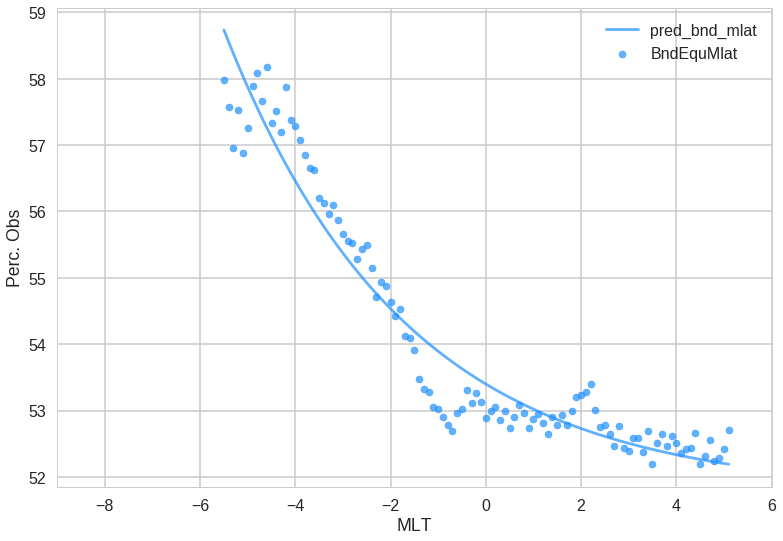

In [51]:
def trgh_lat_pred_func(row):
    normMLT = row["BndNormMLT"]
    # Build the prob functions from the fitting results
    a=probModRes.values["a"]
    k=probModRes.values["k"]
    c=probModRes.values["c"]
    return a * numpy.exp(k * normMLT) + c

testDF["pred_bnd_mlat"] = testDF.apply( trgh_lat_pred_func, axis=1 )

sns.set_style("whitegrid")
sns.set_context("poster")


###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
plt.scatter(testDF['BndNormMLT'],
            testDF['BndEquMlat'],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 50)
plt.plot(testDF['BndNormMLT'],
            testDF['pred_bnd_mlat'],
            color='dodgerblue',
            alpha=0.7,)

plt.xlim( [-9,6] )
plt.xlabel("MLT")
plt.ylabel("Perc. Obs")
plt.legend()